# Boosting이란?


- 여러 개의 약한 Decision Tree를 조합해서 사용하는 Ensemble 기법 중 하나이다.
- 즉, 약한 예측 모델들의 학습 에러에 가중치를 두고, 순차적으로 다음 학습 모델에 반영하여 강한 예측모델을 만드는 것

# GBM(Gradient Boosting Machine)


- GBM은 여러 개의 weak learner를 순차적으로 학습, 예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식
- 가중치의 업데이트 방법은 **경사 하강법(Gradient Descent)**을 사용한다.

# XGBoost란?
- XGBoost는 Extreme Gradient Boosting의 약자이다.
- Boosting 기법을 이용하여 구현한 알고리즘은 Gradient Boost가 대표적인데 이 알고리즘을 병렬 학습이 지원되도록 구현한 라이브러리가 XGBoost이다.
- Regression, Classifier 문제를 모두 지원하며, 성능과 자원 효율이 좋아서 인기 있는 알고리즘이다.
- XGBoost의 장점
    1. GBM 대비 빠른 수행시간 : 병렬 처리로 학습, 분류 속도가 빠르다.
    2. 과적합 규제(Regularization) : 표준 GBM 경우 과적한 규제기능이 없으나. XGBoost는 자체에 과적합 규제 기능으로 강한 내구성을 지닌다.
    3. 분류와 회귀 영역에서 뛰어난 예측 성능을 발휘한다.
        - 즉, CaRT(Classifier and Regression Tree) 앙상블 모델을 사용한다.
    4. Early Stopping(조기 종료) 기능이 있다.
    5. 다양한 옵션을 제공하며 Customizing이 용이하다.

## 필수 라이브러리

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'

# 한글 폰트 설정
mpl.rc('font', family='malgun gothic')
# 유니코드에서 음수 부호 설정
mpl.rc('axes', unicode_minus = False)

warnings.filterwarnings('ignore')

# 로지스틱 회귀와 평가지표

## 데이터셋 - 위스콘신 유방암 예측

In [3]:
!pip install xgboost

In [4]:
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [5]:
X = cancer.data
y = cancer.target

cancer_df = pd.DataFrame(data = X, columns = cancer.feature_names)
cancer_df['target'] = y
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [6]:
print('data shape: ', X.shape)
print('target shape: ', y.shape)

data shape:  (569, 30)
target shape:  (569,)


In [7]:
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [8]:
# 양성 유방암셋과 음성 유방암셋 개수의 파악
np.unique(cancer.target, return_counts = True)

(array([0, 1]), array([212, 357], dtype=int64))

In [9]:
# 30개의 feature가 뭔지를 확인
for i, feature in enumerate(cancer.feature_names):
    print(f'feature{(i+1)} : ', feature)

feature1 :  mean radius
feature2 :  mean texture
feature3 :  mean perimeter
feature4 :  mean area
feature5 :  mean smoothness
feature6 :  mean compactness
feature7 :  mean concavity
feature8 :  mean concave points
feature9 :  mean symmetry
feature10 :  mean fractal dimension
feature11 :  radius error
feature12 :  texture error
feature13 :  perimeter error
feature14 :  area error
feature15 :  smoothness error
feature16 :  compactness error
feature17 :  concavity error
feature18 :  concave points error
feature19 :  symmetry error
feature20 :  fractal dimension error
feature21 :  worst radius
feature22 :  worst texture
feature23 :  worst perimeter
feature24 :  worst area
feature25 :  worst smoothness
feature26 :  worst compactness
feature27 :  worst concavity
feature28 :  worst concave points
feature29 :  worst symmetry
feature30 :  worst fractal dimension


## standarization(표준화)

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(cancer_df.drop('target', axis=1))

## 훈련셋과 테스트셋 분리

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled, y, test_size=0.2, random_state=156)

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.989010989010989
0.9736842105263158


In [14]:
# 훈련 모델을 이용하여 5개의 샘플 예측
print(lr.predict(X_train[:5]))

[0 1 1 1 1]


- 악성 종양(malignant)이 0값으로 1개, 양성종양(benign)이 1값으로 4개 예측

In [15]:
# 로지스틱 회귀가 학습한 계수(기울기아 절편) 추출
print(lr.coef_, lr.intercept_)

[[-0.4721854  -0.38258173 -0.44454406 -0.54316124 -0.14319742  0.72706363
  -0.70746211 -0.96418695 -0.07905176  0.27001329 -1.19658305  0.19765208
  -0.5890956  -0.95010481 -0.31150744  0.75959144  0.14533365 -0.32546344
   0.33243796  0.4394735  -0.86822466 -1.27824666 -0.65146591 -0.90866007
  -0.44631307  0.16705142 -0.8564404  -0.83122684 -1.0734741  -0.54801513]] [0.21706473]


In [16]:
# 예측한 5개의 z값 출력
decisions = lr.decision_function(X_train[:5])
print(decisions)

[-4.66877599  3.18944318 11.91185818  8.7300568   2.34636033]


In [17]:
from scipy.special import expit
print(expit(decisions))

[0.00929651 0.96043507 0.99999329 0.99983837 0.91264449]


In [18]:
# 예측하기
predict = lr.predict(X_test)

### 평가지표
    1. 회귀(regression): MAE, MSE, RMSE, SSE...
    2. 분류(classification): 정확도, 정밀도, 재현율(민감도), F1 스코어, ROC 커브
    3. 클러스터링(clustering): DBI, 엘보우 메서드, 실루엣 계수

In [19]:
# 정확도(Accuracy) : 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표
# 이진 분류일 경우 데이터에 따라 모델의 성능이 왜곡될 수 있다.
# 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수

from sklearn.metrics import accuracy_score
accuracy_score(y_test, predict)

0.9736842105263158

### 혼돈 행렬(Confusion Matrix, 오차 행렬)

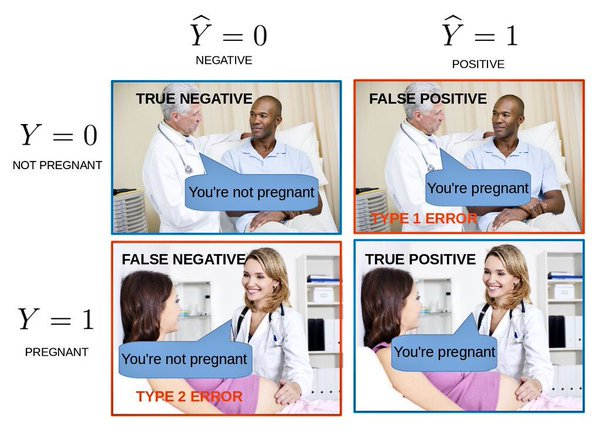

In [20]:
from IPython.display import Image
Image('https://skappal7.files.wordpress.com/2018/08/confusion-matrix.jpg', width=600)

In [21]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predict)
cm

array([[35,  2],
       [ 1, 76]], dtype=int64)

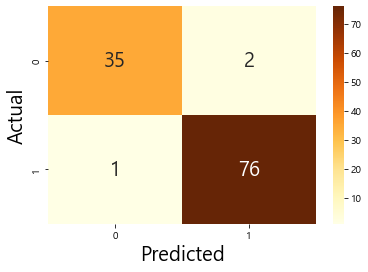

In [22]:
# 혼돈 행렬 시각화
sns.heatmap(cm, annot=True, annot_kws={'size':20}, cmap='YlOrBr')
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.show()

In [23]:
TN, FP, FN, TP = cm.ravel()

#### 정밀도(Precision)
- Positive로 예측한 전체 건수에서 옳게 예측한 건수의 비율

In [24]:
Precision = TP/(FP+TP)
Precision

0.9743589743589743

In [25]:
from sklearn.metrics import precision_score
precision_score(y_test, predict)

0.9743589743589743

#### 재현율(Recall), 민감도
    - 실제 Positive인 전체 건수에서 옳게 예측한 건수의 비율
    - TPR(True Positive Rate)

In [26]:
recall = TP / (FN+TP)
recall

0.987012987012987

In [27]:
from sklearn.metrics import recall_score
recall_score(y_test, predict)

0.987012987012987

#### F1 Score
    - 재현율과 정밀도의 균을 나타내는 수치

In [28]:
f1 = 2 * (Precision * recall) / (Precision + recall)
f1

0.9806451612903225

In [29]:
from sklearn.metrics import f1_score
f1_score(y_test, predict)

0.9806451612903225

# XGBoost 모델 학습

In [30]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

In [31]:
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [32]:
params = {'max_depth':3,
         'eta':0.05,
         'objective':'binary:logistic',
         'eval_metric':'logloss'
         }
num_rounds = 400

In [33]:
eval_list = [(dtr, 'train'), (dval, 'eval')]

xgb_model = xgb.train(params = params, dtrain=dtr, num_boost_round=num_rounds,
                     early_stopping_rounds=50, evals=eval_list)

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52930
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31892	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

[170]	train-logloss:0.01312	eval-logloss:0.26133
[171]	train-logloss:0.01304	eval-logloss:0.26148
[172]	train-logloss:0.01297	eval-logloss:0.26157
[173]	train-logloss:0.01285	eval-logloss:0.26253
[174]	train-logloss:0.01278	eval-logloss:0.26229
[175]	train-logloss:0.01267	eval-logloss:0.26086


In [34]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score

def  get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion)
 
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, \
    재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [36]:
from sklearn.preprocessing import Binarizer

def get_clf_eval_thres(y_test, pred_po, threshold, f1_show=False, auc_show=False):
    eval_df = pd.DataFrame()
    
    for thres in threshold:
        # threshold에 따른 예측 분류 값
        binarizer = Binarizer(threshold = thres)
        binarizer.fit(pred_po)
        thres_pred = binarizer.transform(pred_po)
        
        # 평가지표  
        accuracy = accuracy_score(y_test, thres_pred)
        precision = precision_score(y_test, thres_pred)
        recall = recall_score(y_test, thres_pred)
        f1 = f1_score(y_test, thres_pred)
        auc = roc_auc_score(y_test, pred_po)
        
        # 데이터 프레임 형태
        eval_lst = np.array([accuracy, precision, recall, f1, auc]).reshape(-1,1)
        temp = pd.DataFrame(eval_lst, columns=[thres], 
                            index = ["정확도", "정밀도", "재현율", "F1스코어", "AUC"])
        eval_df = pd.concat([eval_df,temp], axis=1)
        
    eval_df.columns.names = ["임계값"]
    
    if f1_show == False:
        eval_df.drop("F1스코어", axis=0, inplace=True)
        
    if auc_show == False:
        eval_df.drop("AUC", axis=0, inplace=True)
        
    return round(eval_df, 4)

In [37]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615,     재현율: 0.9740, F1: 0.9677, AUC:0.9937


In [39]:
from lightgbm import LGBMClassifier

ModuleNotFoundError: No module named 'lightgbm'